# Fitting Params v. Time
In this notebook, we look at the changes in fitting parameters in TFO PPG sheep data evolving across time. If our inverse modelling approach is to be based on these fitting parameters, they should show some sort of pattern in time. Preferably, these patterns should have harmonic components at FHR & MHR.  
We test this theory out on baseline data. In this part, we know for sure the absorptions co-effs are not changing and hopefully the sheep remains motionless. Therefore the only change would be pulsation.  

## Spectral Peaks
Looking at this data, we see that the alphas do show oscillations across time. Looking at their spectrum, these variations do have a spike at MHR, FHR and RR. But there are also other smaller peaks around that. Also note that there is a strong DC for all the alphas.

I am not yet sure how to remove the unwanted peaks.

**NOTE**: The apha1 for both wavelength(That's the co-eff for SDD) has a much smaller value than the rest but even then, it fluctuates/shows waves.

## Results for Baselines
In the baseline case, the alphas fluctuate around an average value. We verify this by calculating an 800 point moving average filter. Testing on a bunch of baseline files, (Except s1r1 2022) the moving average seems to stay constant throughout the round. 

## Results for Regular Rounds
In a regular round, the saturation falls as time goes on. We would thus expect some sort of trend added on top of the oscillations in the alphas. To verify this, We ran the same test as the baseline -- finding a moving average. Indeed, the alphas do show such a trend. The average over the entire round, for each alpha slowly drift vertically.

## Value Ranges for Alpha


## Next Step
Looking at these properties, it should indeed be possible to track absorption co-eff and layer thicknesses using the alphas. But this whole process hinges on finding the ranges for the alphas. We need to somehow connect the ranges found in experiment with the alpha ranges from our simulations. 

## Note
Test code. Some parts are extremely inefficient/slow (especially the fitting part)

## How to use this notebook
I have a note of all the rounds which contain a baseline. Just change the tag to whichever data needed and run all the cells. 


In [1]:
from inverse_modelling_tfo.data.intensity_interpolation import interpolate_exp_chunk, get_interpolate_fit_params
from typing import List, Union
import pandas as pd

In [2]:
# Load data
import numpy as np
import matplotlib.pyplot as plt
from TFO_dataset import SheepData
from itertools import product

In [3]:
# Print available tags with baseline
# all_tags = SheepData('iq_demod_optical').get_available_tags()
# all_tags = filter(lambda tag: tag['additional_info'] == "Baseline", all_tags)
# for tag in all_tags:
#     print(tag)

In [4]:
# {'experiment_number': 3, 'experiment_round': 1, 'experiment_year_prefix': 'su2020', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 3, 'experiment_round': 2, 'experiment_year_prefix': 'su2020', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 4, 'experiment_round': 1, 'experiment_year_prefix': 'su2020', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 4, 'experiment_round': 2, 'experiment_year_prefix': 'su2020', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 4, 'experiment_round': 3, 'experiment_year_prefix': 'su2020', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 5, 'experiment_round': 1, 'experiment_year_prefix': 'su2020', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 5, 'experiment_round': 2, 'experiment_year_prefix': 'su2020', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 1, 'experiment_round': 1, 'experiment_year_prefix': 'sp2021', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 1, 'experiment_round': 2, 'experiment_year_prefix': 'sp2021', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 1, 'experiment_round': 3, 'experiment_year_prefix': 'sp2021', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 2, 'experiment_round': 1, 'experiment_year_prefix': 'sp2021', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 2, 'experiment_round': 2, 'experiment_year_prefix': 'sp2021', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 2, 'experiment_round': 3, 'experiment_year_prefix': 'sp2021', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 1, 'experiment_round': 1, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 1, 'experiment_round': 2, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 1, 'experiment_round': 3, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 2, 'experiment_round': 1, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 2, 'experiment_round': 2, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 2, 'experiment_round': 3, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 4, 'experiment_round': 1, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 4, 'experiment_round': 2, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 7, 'experiment_round': 1, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 7, 'experiment_round': 3, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 10, 'experiment_round': 1, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 10, 'experiment_round': 2, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 10, 'experiment_round': 3, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 11, 'experiment_round': 1, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}
# {'experiment_number': 11, 'experiment_round': 2, 'experiment_year_prefix': 'sp2022', 'additional_info': 'Baseline', 'data_version': 'iq_demod_optical', 'experiment_type': 'sheep'}

In [5]:
tag = {'experiment_number': 5, 'experiment_round': 1, 'experiment_year_prefix': 'su2020',
       'additional_info': '', 'data_version': 'iq_demod_optical'}
data = SheepData('iq_demod_optical').get_data_from_tag(tag)
print(f'Sample Length : {len(data)}')


Sample Length : 263391


In [6]:
%matplotlib widget

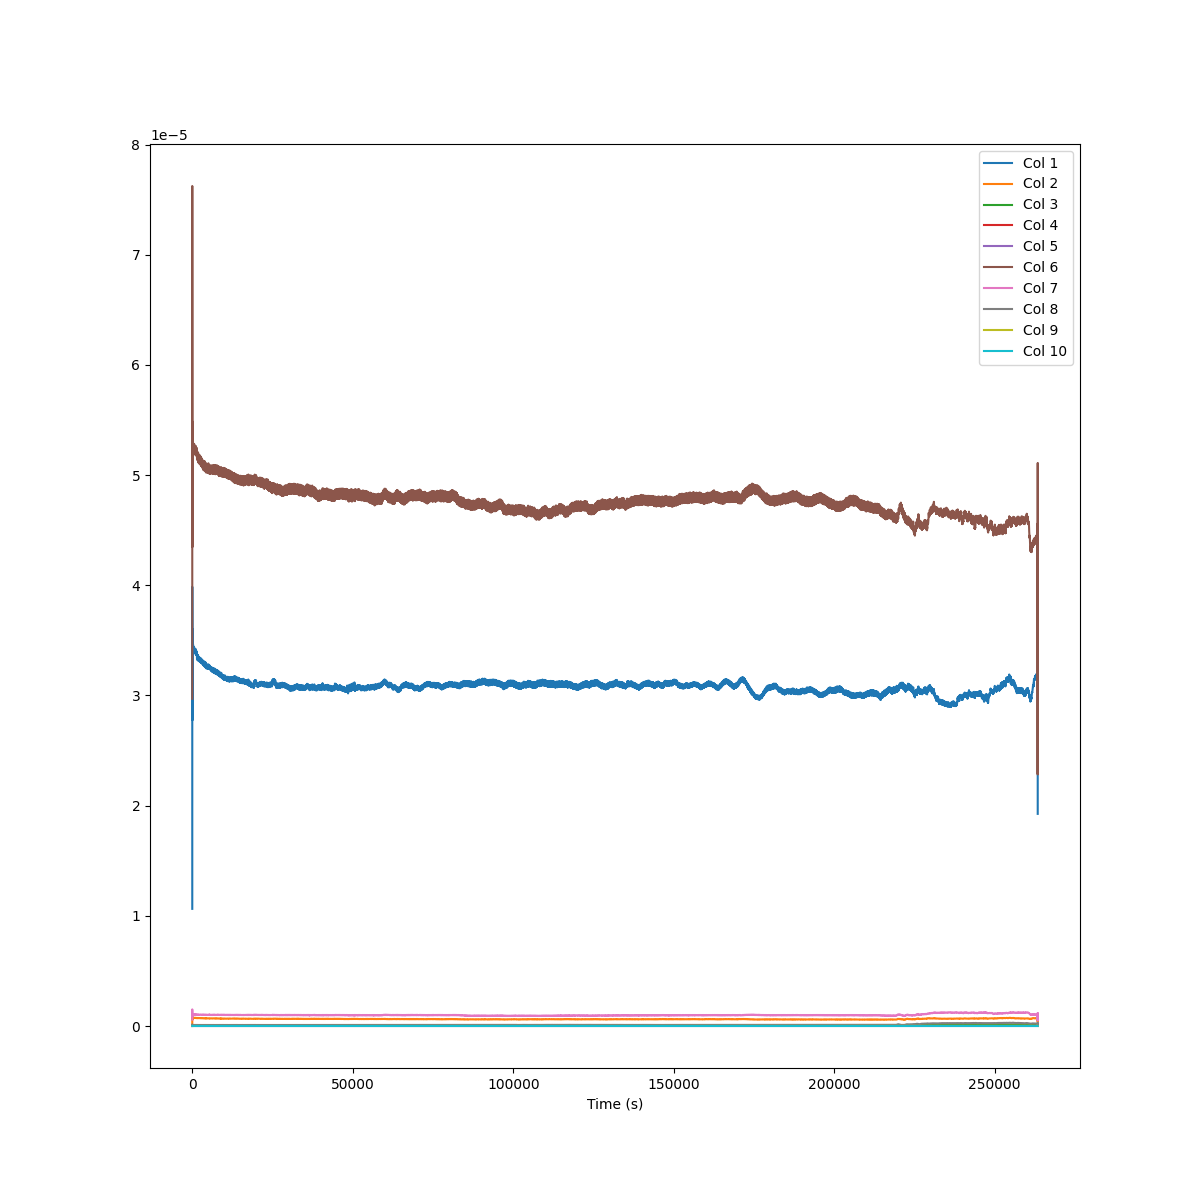

In [7]:
# Plot waveform
plt.figure(figsize=(12, 12))
for col in range(data.to_numpy().shape[1]):
    plt.plot(data.to_numpy()[:, col], label=f'Col {col + 1}')
time_axis = np.arange(0, data.to_numpy().shape[0]/80, 1/80)
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [8]:
def prepare_patient_ppg(ppg_data : pd.DataFrame, sample_number : Union[int, List], SDD = [15, 30, 45, 70, 100], weights=[1.0, -1.0]) -> np.ndarray:
    """Create fitting parameters from PPG data. 

    Args:
        ppg_data (pd.DataFrame): PPG data DataFrame. You can feed data directly from the the TFO_dataset package.
        (Note: This should ideally be the optically normalized data)
        sample_number (int): which sample to choose. You can either pass a single integer or an array
        SDD (_type_, optional): Detector distances in TFO device(in mm). Defaults to SDD=[15, 30, 45, 70, 100].
        weights: Exponential weights applied during fitting to the detectors
    """
    # The code is generalized to run on any array. make necessary conversions 
    if isinstance(sample_number, int):
        sample_number = [sample_number]
    
    patient_features = []
    for sample_point in sample_number:
        # Pick a point in time
        spatial_intensity = ppg_data.iloc[sample_point].copy()  # at 300s with 80Hz sampling freq.
        spatial_intensity *=  np.pi * 4   # from unit area -> pi r^2 area -> match simulation
        # Reshape ppg data to fit the format
        spatial_intensity_wv1 = pd.DataFrame(data={
            'SDD' : SDD,
            'Intensity' : spatial_intensity.to_numpy()[:5]
        })
        spatial_intensity_wv2 = pd.DataFrame(data={
            'SDD' : SDD,
            'Intensity' : spatial_intensity.to_numpy()[5:]
        })
        alpha_wv1 = interpolate_exp_chunk(spatial_intensity_wv1, weights=weights, return_alpha=True).flatten()
        alpha_wv2 = interpolate_exp_chunk(spatial_intensity_wv2, weights=weights, return_alpha=True).flatten()
        patient_features.append([alpha_wv1[0], alpha_wv2[0], alpha_wv1[1], alpha_wv2[1], alpha_wv1[2], alpha_wv2[2], alpha_wv1[3], alpha_wv2[3]])
        
    return np.array(patient_features)

In [9]:
# features = prepare_patient_ppg(data, np.arange(5000, 170000, 10))
features = prepare_patient_ppg(data, np.arange(0, len(data), 10))

In [10]:
features.shape[0] / 8

3292.5

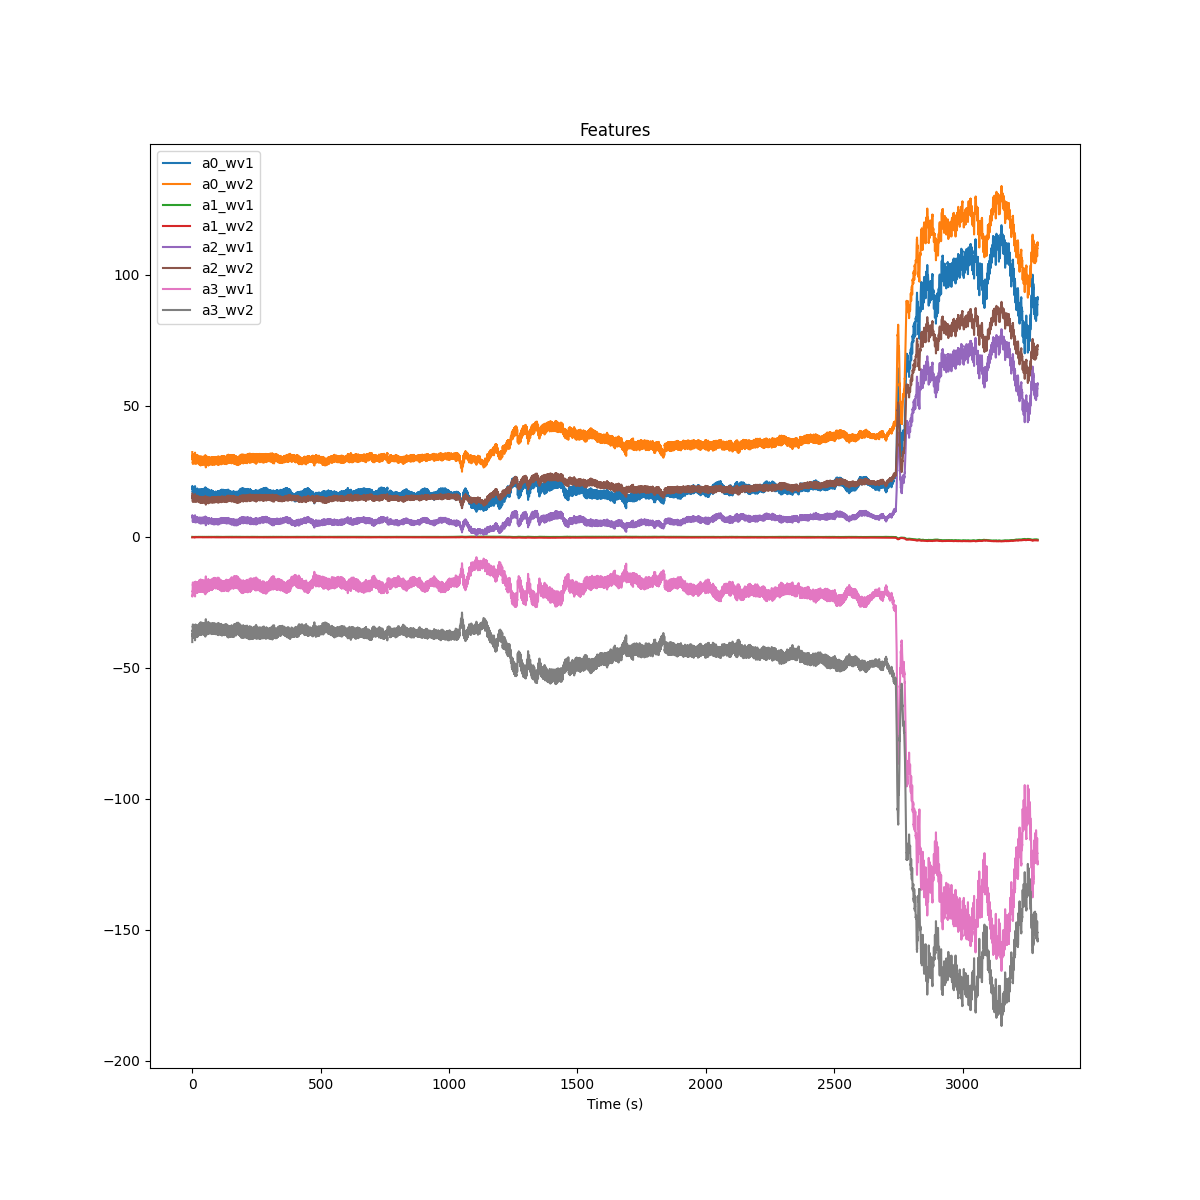

In [11]:
plt.figure(figsize=(12, 12))
plt.title('Features')
feature_names = [f'a{x}_wv{y}' for x,y in product(list(range(4)), list(range(1, 3)))]
time_axis = np.arange(0, features.shape[0]/8, 1/8)
for col in range(features.shape[1]):
    plt.plot(time_axis, features[:, col], label=feature_names[col])
plt.xlabel('Time (s)')
plt.legend()
plt.show()

## Trend Checking
I wanted to know, during a whole round, does the moving average of the alphas change at all? If they do change, this can be used to justify that the alphas can indeed track changes in saturation (During actual experiments). Similarly, if the moving average should not change during the baseline since everything is stable in those rounds.  

These two checks provide a solid starting point for claiming inverse modelling as an actual usable approach. 

In [12]:
# Trend Checker!
features_trend = []
m = 80
for i in range(features.shape[1]):
    features_trend.append(np.convolve(features[:, i], np.ones(m), 'valid') / m)


## Note
Using a very ad-hoc MA filter. It just convolves the signal with an $m$ length unity filter and then takes the average. The filter mode is set to "valid" to make averaging only when enough points are available. Which means, the MA's length is smaller than the original signal.

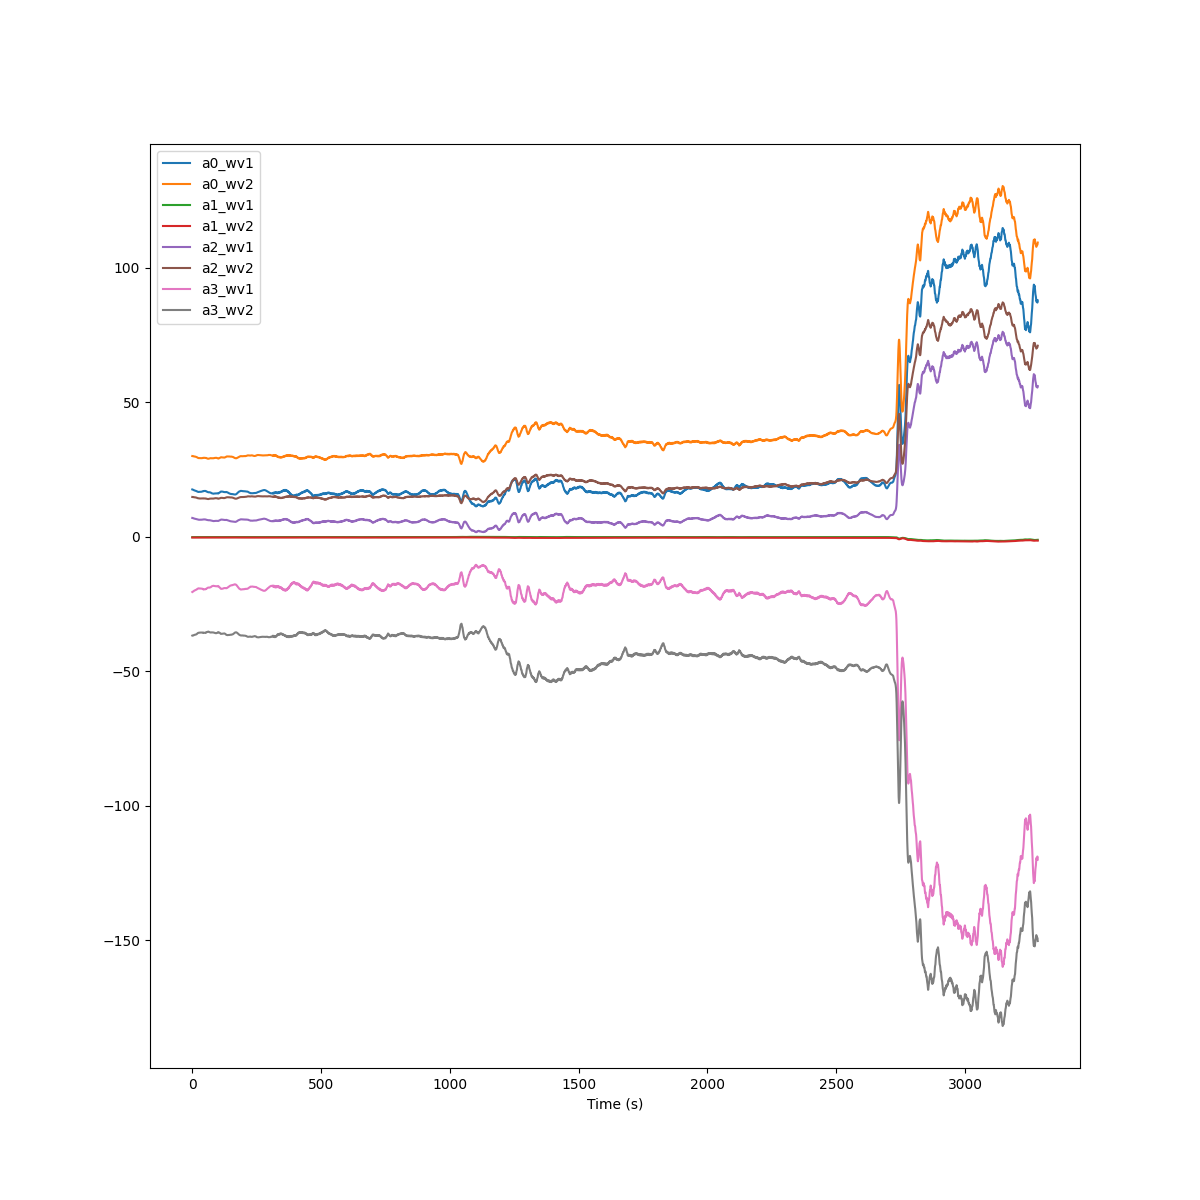

In [13]:
plt.figure(figsize=(12, 12))
time_axis = np.arange(0, len(features_trend[0])/8, 1/8)
for col, trend in enumerate(features_trend):
    plt.plot(time_axis, trend, label=feature_names[col])
plt.xlabel('Time (s)')
plt.legend()
plt.show()

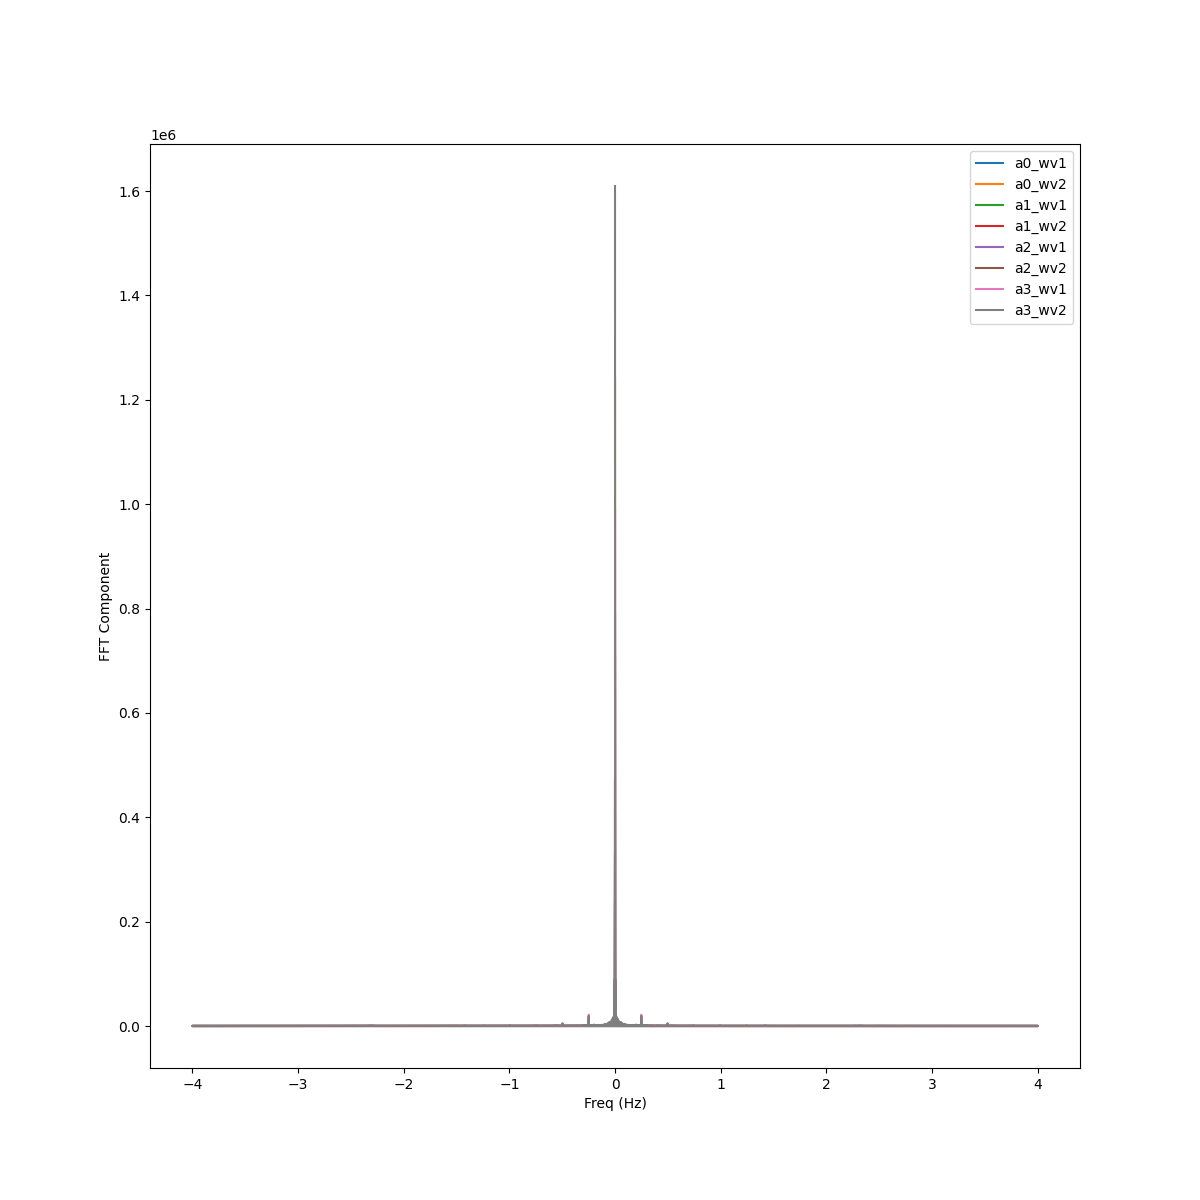

In [14]:
plt.figure(figsize=(12, 12))
n = features.shape[0]
fft_bin = np.fft.fftfreq(n, 1/8)
features_fft = np.fft.fft(features, n=n, axis=0)
features_fft.shape
for col in range(features_fft.shape[1]):
    plt.plot(fft_bin, np.abs(features_fft[:, col]), label=feature_names[col])
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Component')
plt.legend()
# plt.xlim(0, 5)
plt.show()

In [15]:
# Value range
features_df = pd.DataFrame(features)
features_df.describe()

,0,1,2,3,4,5,6,7
count,26340.000000,26340.000000,26340.000000,26340.000000,26340.000000,26340.000000,26340.000000,26340.000000
mean,29.913247,47.011496,-0.293118,-0.519746,15.369814,26.872412,-37.669806,-61.112222
std,29.160031,29.958716,0.445719,0.462491,21.029904,21.758223,42.141623,43.511330
min,9.462841,24.761034,-1.634031,-1.845863,0.431667,10.844243,-165.700000,-186.730845
25%,16.236025,30.482298,-0.133620,-0.390653,5.656908,15.112027,-23.232050,-50.126047
50%,17.632022,35.658034,-0.110269,-0.339024,6.617674,18.525631,-20.053829,-44.499573
75%,20.155543,39.744341,-0.089930,-0.277549,8.074693,21.253034,-18.106334,-37.404662
max,118.825785,133.775090,0.028317,-0.180111,79.132730,89.583203,-7.866496,-28.980958
